# Project 2 report:  New York City Taxi Data Exploration

MATH11199: Python Programming

Dept. of Mathematics, University of Edinburgh

Dec 6<sup>th</sup> 2022

<!-- 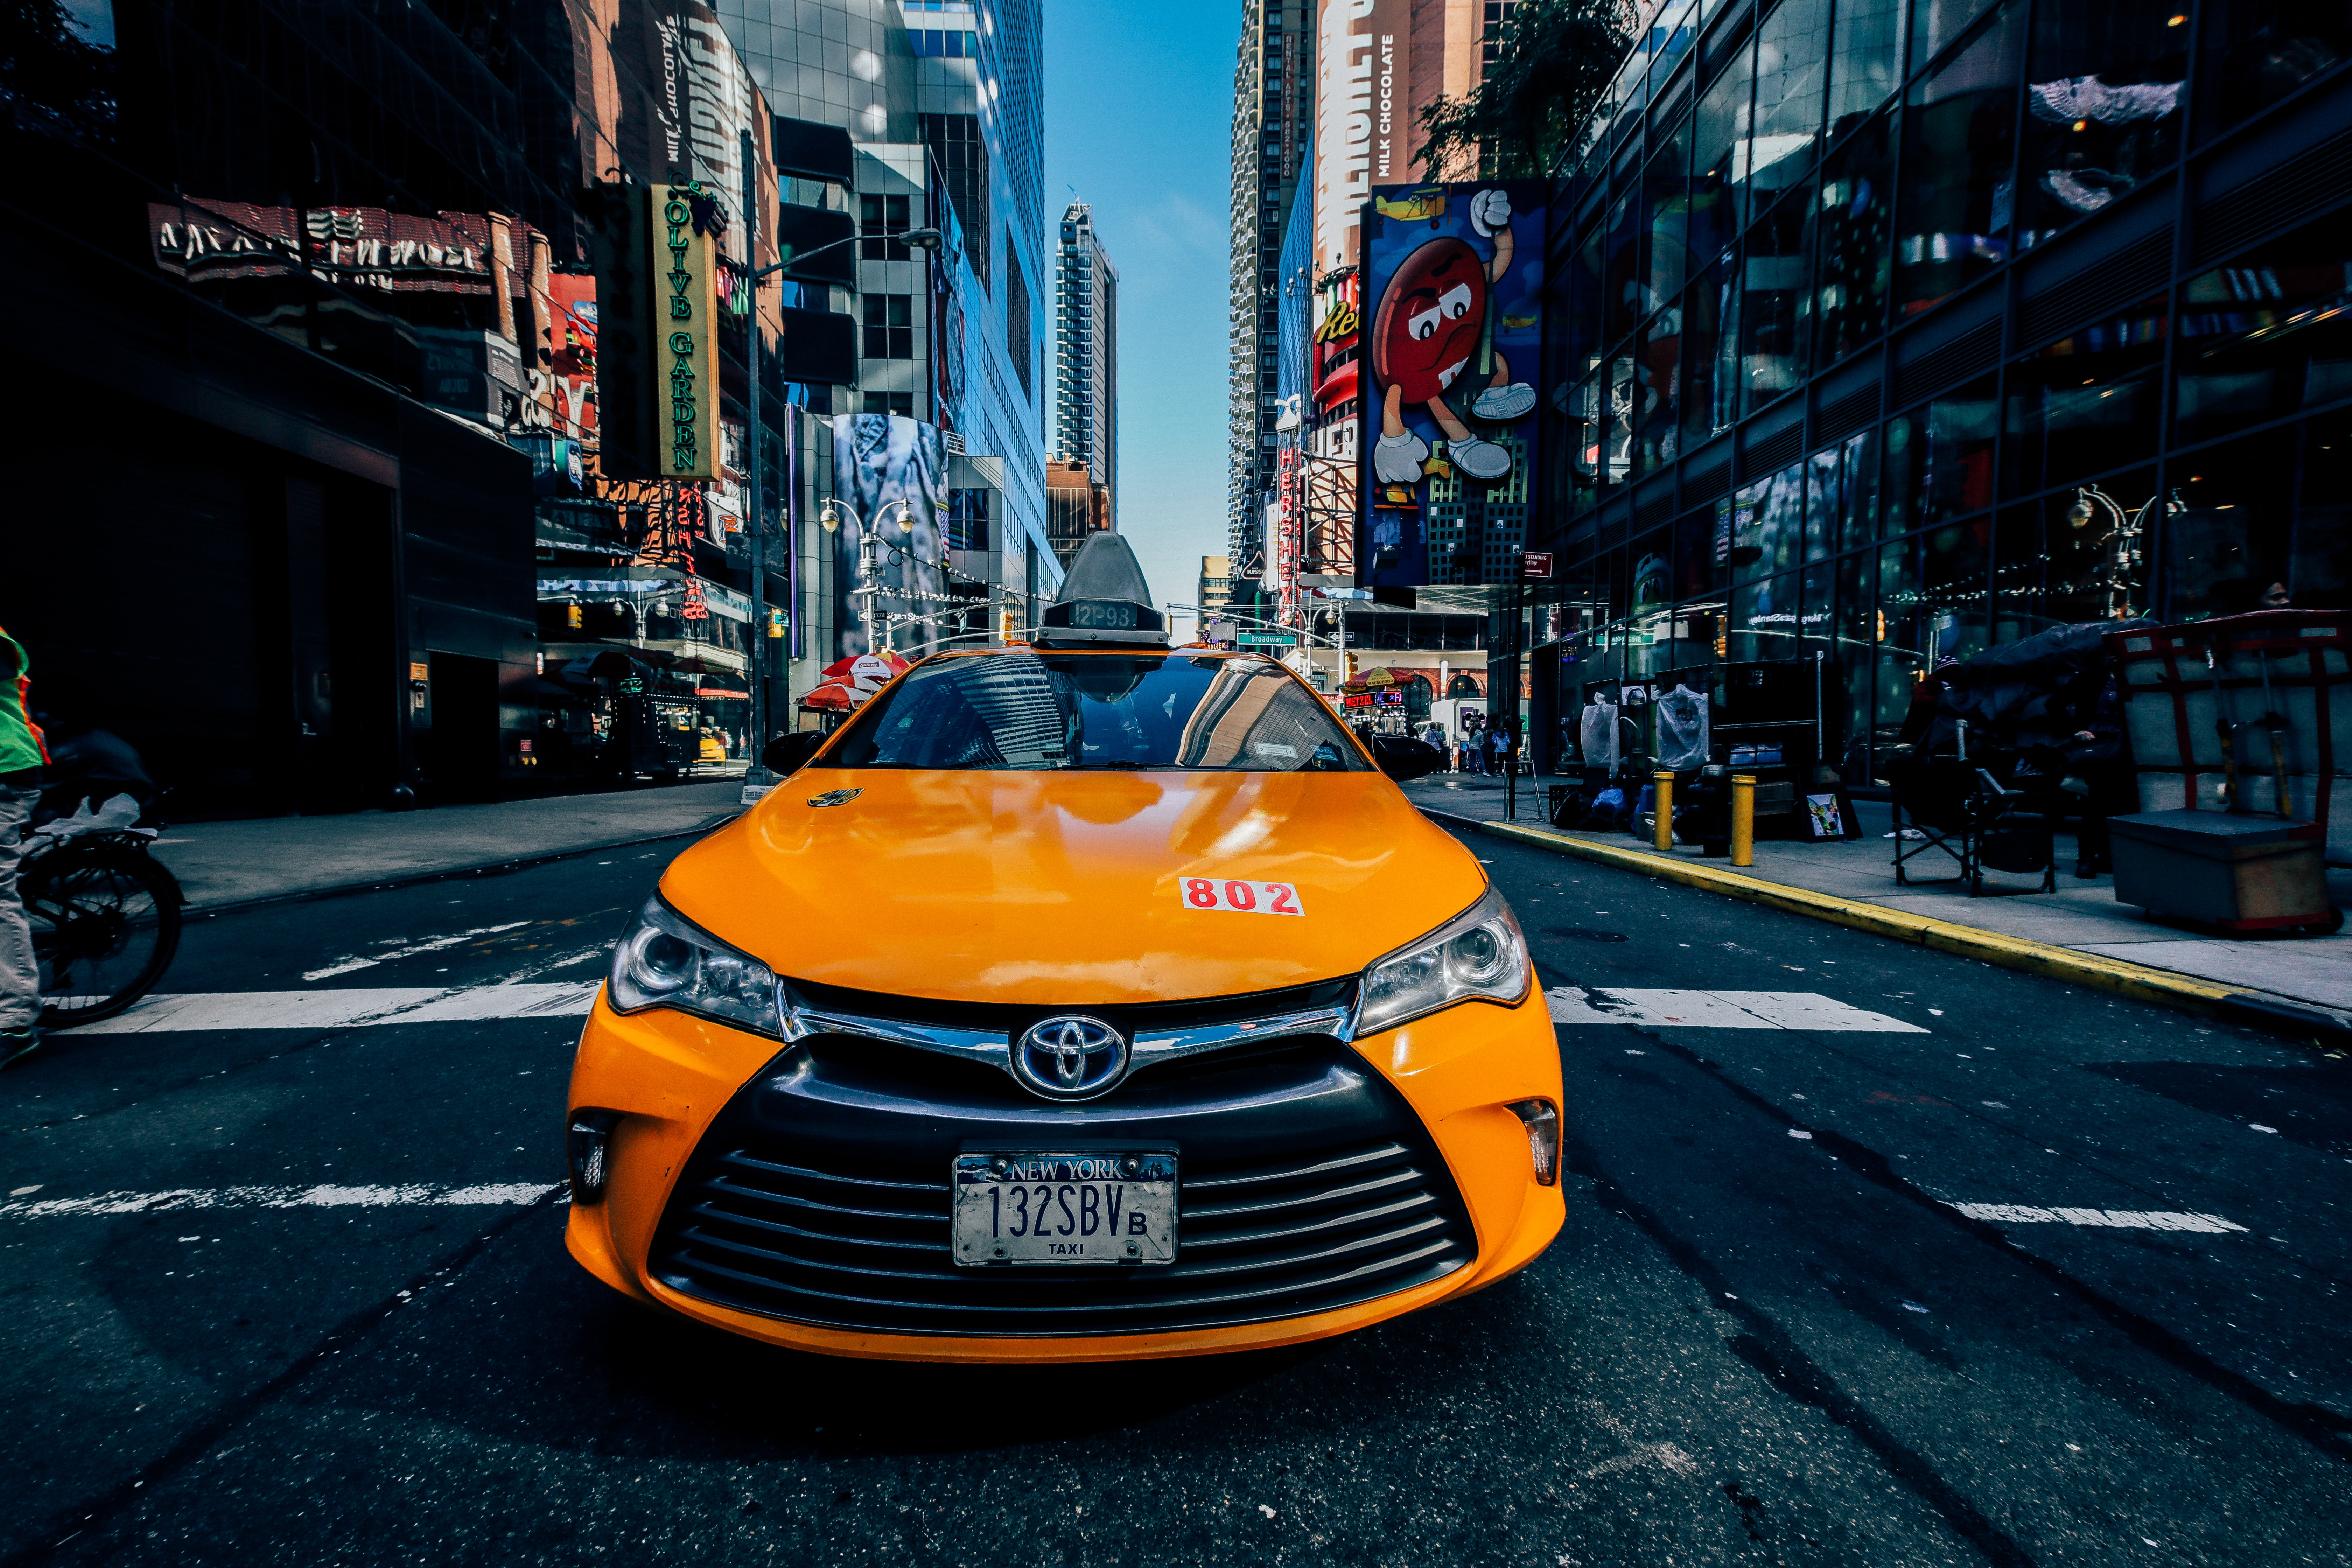
 -->
<div>
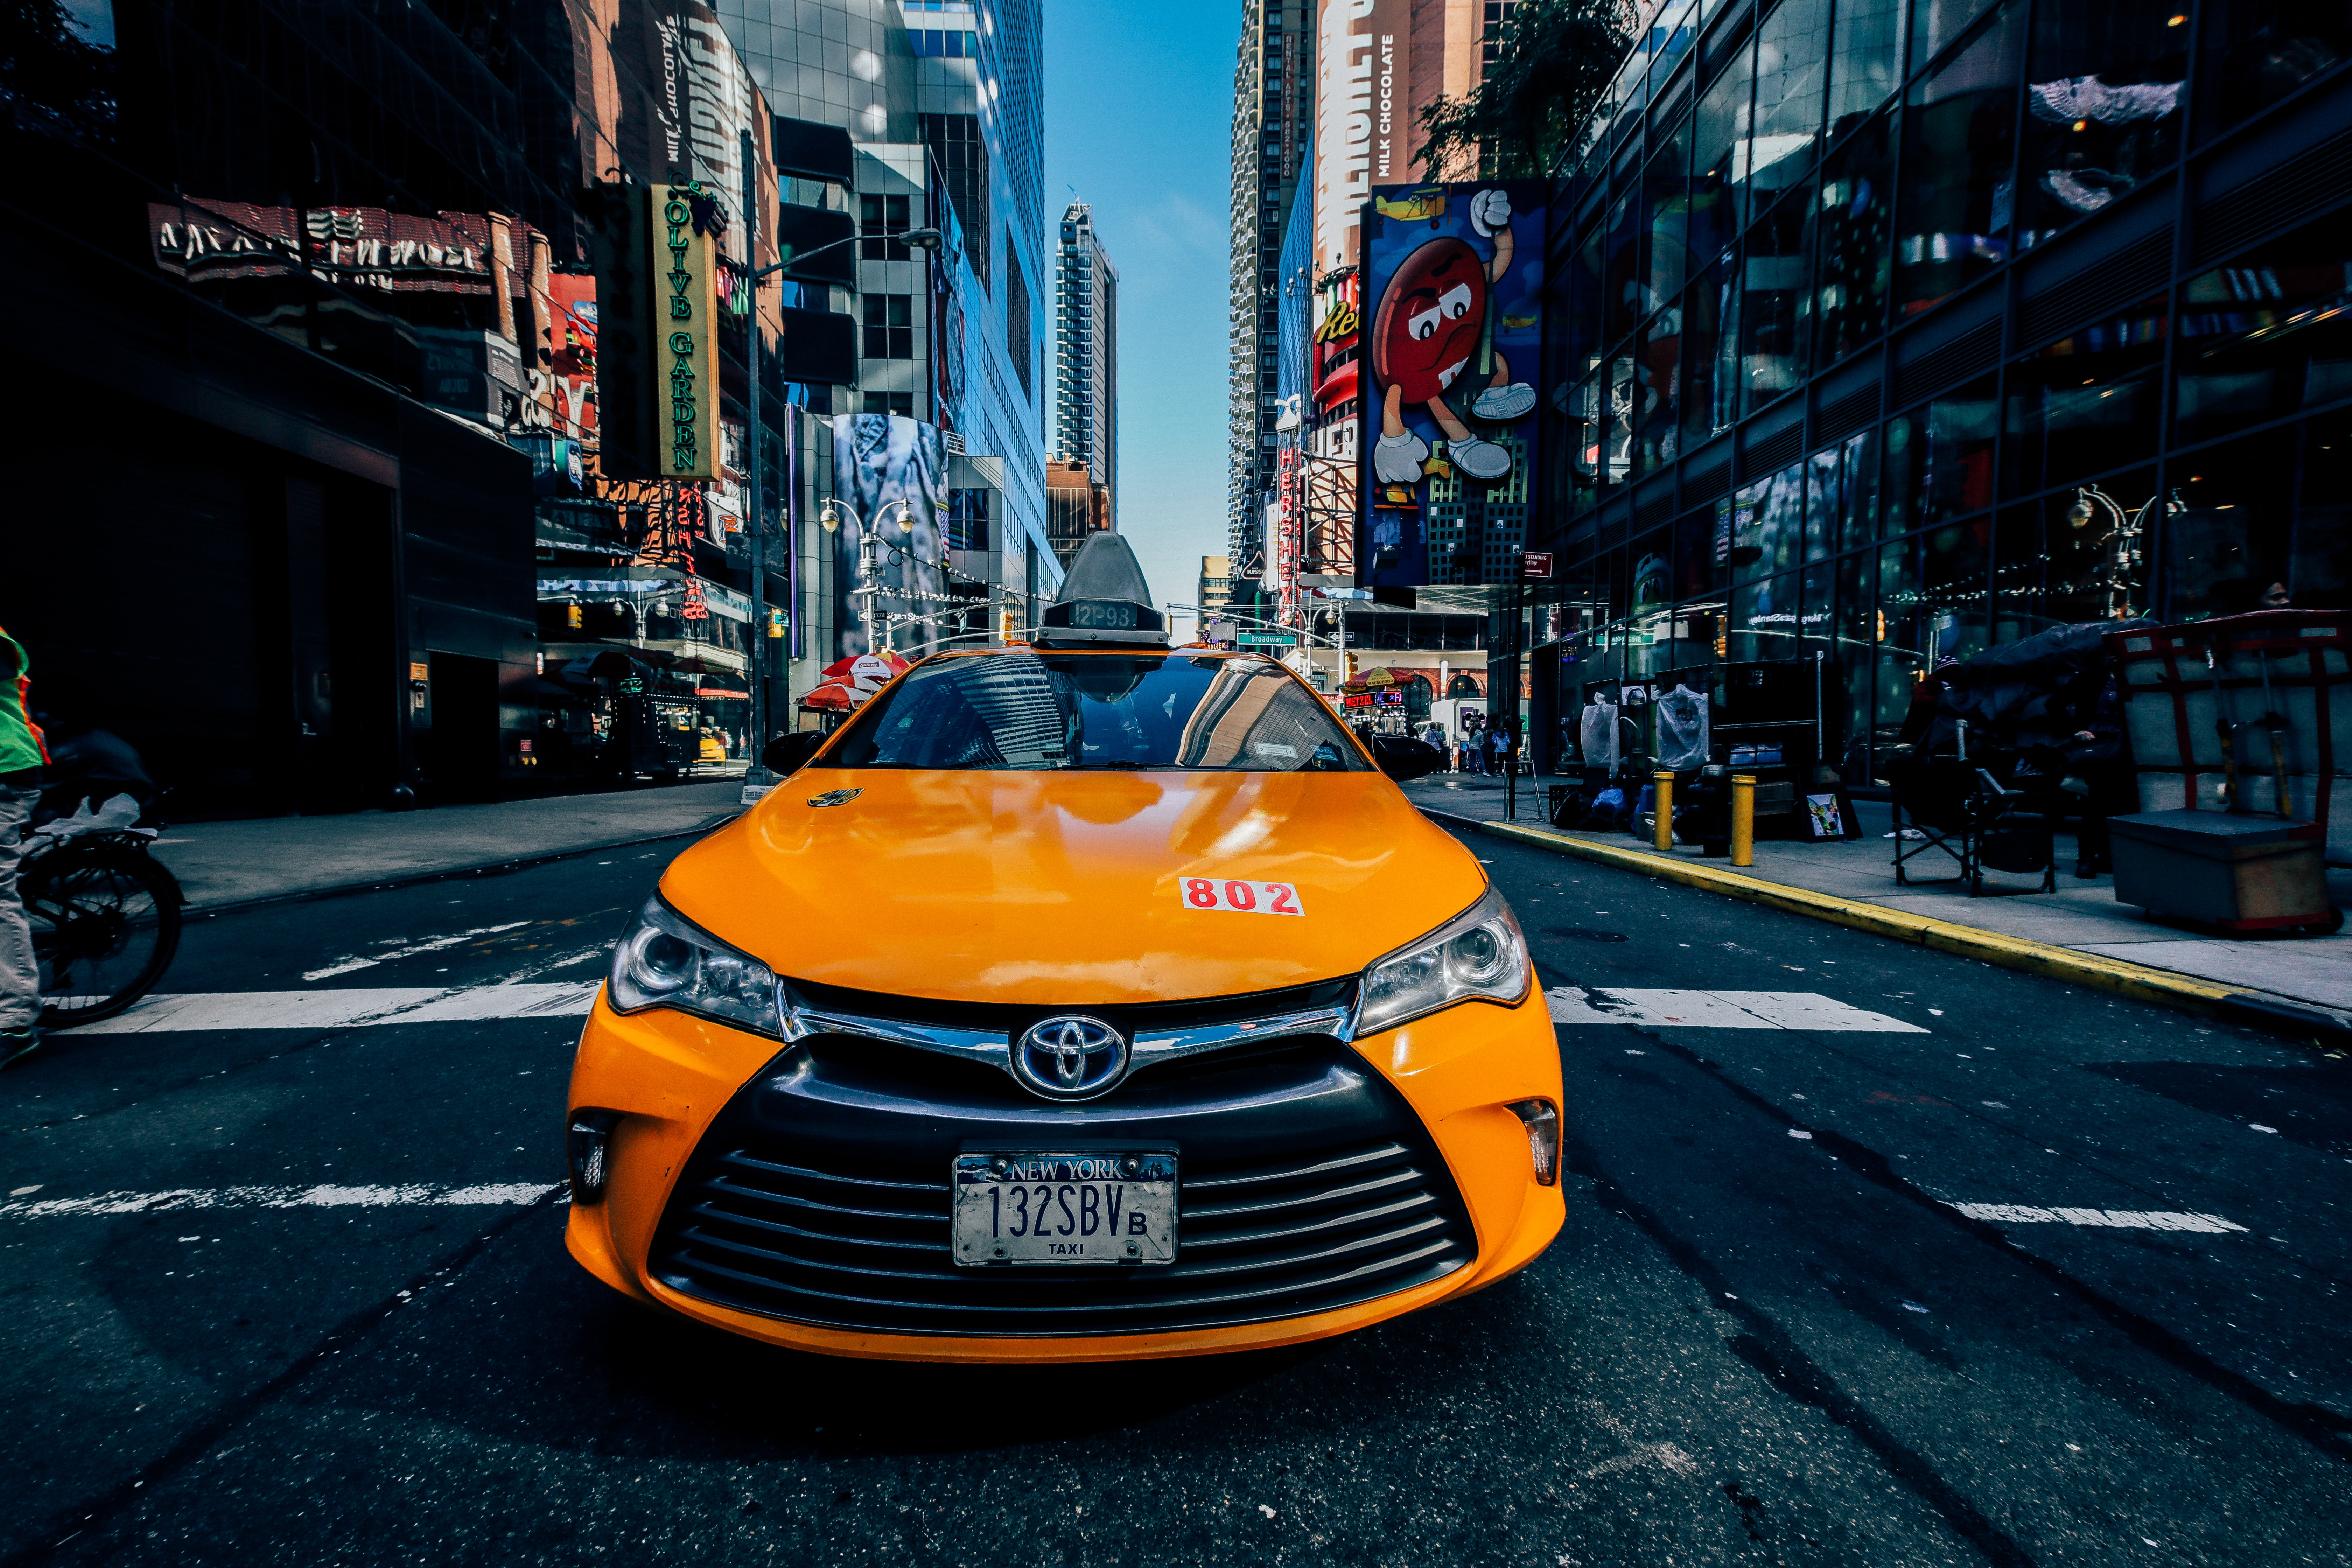
</div>

Image source: Drew Dizzy Graham, Unsplash, https://unsplash.com/photos/x6QPa_5ZqOc

## 1 Introduction

The New York City Taxi and Limousine Commission (NYC TLC) publishes monthly data of every taxi trip taken across its service zone. The purpose of this project is provide consultation services for a taxi management company to formulate strategic locations within Manhattan to optimise its pick-up rate of passengers.

This project aims to accomplish this using two methods: first, historical calendar, weather and taxi data are used to train a decision tree regressor model that can then be used to predict demand for a given day by knowing its calendar properties and expected weather conditions. Secondly, drop-off hotspots in Manhattan are analysed on days of exceptional peak demand due to events and public holidays. The drop-off hotspots are plotted on heatmaps, and this information is used to find the most popular destinations for passengers. The distribution of pick-up locations is also analysed for passengers heading to these hotspots, from which a recommendation for strategic locations where taxis should patrol can be produced.

## 2 Data handling

### 2.1 Data import and cleaning

Prior to the investigations performed in this report, the required libraries are imported and necessary configurations are set. Taxi data is imported from the TLC using the `get_taxi_data` function provided in the project handout. The taxi data contains location IDs for pick-up and drop-off, which is an integer number between 1 and 263. Their associated zones within the city and their geographic properties are imported separatedly from a shapefile from the TLC into a Geopandas `GeoDataFrame`.

Weather data is imported from the MeteoStat weather application programming interface (API). The weather data is taken at daily intervals, and is unique to each taxi zone by querying the weather from the weather station that is nearest to the zone's centroid coordinates.

The cleaning process of the taxi data involves deleting any data with pick-up locations outside a selected borough of the city, which is chosen to be Manhattan, as the taxi management company manages yellow taxi cabs. Additionally, any rows with invalid values are removed. These invalid values may be:
- Pickup location IDs 264 and 265, as they are equivalent to NaN values and not associated with any zone in New York City.
- Rows with a pickup date outside the queried month.
- Negative taxi fare amounts and positive taxi fare amounts greater than the 99<sup>th</sup> percentile.

Cleaning the weather data involves dropping columns where most or all elements have NaN values, namely the `tsun` and `wgpt` columns. Additionally, some columns are mostly complete but contain some NaN elements, and here these values are replaced with zero values. The latter columns are `wdir` and `pres`, measures of wind direction and air pressure, respectively.

In [1]:
## Import libraries

# taxi and weather data import
from utils import get_taxi_data
from meteostat import Point, Daily, Stations

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas

# numerical operations
import pandas as pd
import numpy as np
from datetime import date, datetime

# data handling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# interactivity
import ipywidgets as widgets

# regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

## Configuration
pd.set_option('display.precision', 3)
%matplotlib inline
taxi_zone_path = 'data/taxi_zones/taxi_zones.shp'
taxi_data_path = '~/Documents/PythonProject/data/taxi_data/'

In [2]:
def import_taxi_zones(path,borough_name):
    '''
    Imports shapefile data for New York taxi zones and converts it to a geopandas geodataframe. Returns the 
    geodataframe for the whole of New York City and the subset of elements of a particular borough.
    
    Inputs:
    > path (str): local path to shapefile.
    > borough_name (str): name of the particular borough to produce the subset dataframe for.
    
    Outputs:
    < zones (gdf): geodataframe containing id number, name, and coordinate shape of each of the 263 New York zones.
    < borough (gdf): geodataframe containing the same columns as zones, but for the subset rows of a borough within
        New York city.
    '''
    # import taxi zones from NYC Taxi & Limousine Commision, and set index
    zones = geopandas.read_file(path)
    zones = zones.set_index('OBJECTID')
    zones.index.rename('grid',inplace=True)
    
    # change coordinate reference system to New York specific
    # source: https://epsg.io/?q=new+york
    zones.to_crs('EPSG:32118')

    # save zones within Manhattan
    borough = zones.loc[zones.borough.str.contains(borough_name)]
    
    return zones, borough

In [3]:
def clean_data(df,month,year,borough):
    
    # drop data for pick-ups outside selected borough
    df.drop(df[~df.PULocationID.isin(borough)].index, inplace=True)
    
    # remove data points where pick-up date is not in desired month
    df.drop(df.loc[df.tpep_pickup_datetime.dt.month != int(month)].index,inplace=True)

    # remove data points where pick-up date is not in desired year
    df.drop(df.loc[df.tpep_pickup_datetime.dt.year != int(year)].index,inplace=True)
    
    # drop any data where pick-up or drop-off LocationID is 264 or 265, as they are equivalent to NaN values
    df.drop(df.loc[(df.PULocationID==264)|(df.PULocationID==265)].index,inplace=True)
    
    # drop any data with negative fare_amount
    df.drop(df.loc[df.fare_amount < 0].index,inplace=True)

    # drop any data beyond 99th percentile of fare_amount
    df.drop(df.loc[df.fare_amount > df.fare_amount.quantile(0.99)].index,inplace=True)
    
    return df

In [4]:
def get_weather_data(df,borough):
    '''
    Imports daily weather data using Meteostat API for each grid from the weather station nearest to the centroid
    of that particular grid. The weather data is also cleaned, dropping any columns with most or all NaN values, 
    otherwise filling NaNs with zero.
    
    Inputs:
    > df (df): pandas dataframe of cleaned daily summary taxi data for each date and each grid within a 
        selected borough.
    > borough (gdf): geopandas dataframe of all zones within a selected borough.
    
    Outputs:
    < weather (df): pandas dataframe of cleaned weather data per day and grid.
    '''
    # instantiate empty dataframe for weather data
    weather = pd.DataFrame()
    
    # obtain daily weather data for each city grid
    for grid in df.grid.unique():
        
        # define start and end times for weather query
        start_time = df.loc[df.grid == grid].date.min().to_pydatetime()
        end_time = df.loc[df.grid == grid].date.max().to_pydatetime()
        
        # find the centroid of city grid
        centroid = borough.to_crs('EPSG:4326').loc[grid].geometry.centroid

        # define Meteostat Point at the centroid coordinates
        point = Point(lon=centroid.x,lat=centroid.y)

        # obtain grid weather data from weather station nearest to point using Meteostat Daily API
        query = Daily(point,start_time,end_time)
        grid_weather = query.fetch()
        
        # fill NaN values in wind direction and air pressure columns with zero
        grid_weather.wdir.fillna(0,inplace=True)
        grid_weather.pres.fillna(0,inplace=True)
        
        # add grid number and date to grid weather data
        grid_weather.insert(0,'grid',grid)
        grid_weather.insert(0,'date',grid_weather.index.to_frame())
        
        # concatenate grid weather dataframe onto weather dataframe
        weather = pd.concat([weather,grid_weather],axis=0,ignore_index=True)
    
    # drop tsun and wpgt columns as it is mostly incomplete data
    weather.drop(columns=['tsun','wpgt'],inplace=True)
        
    return weather

### 2.2 Data Processing

Following the import and cleaning processed, the cleaned data is processed to extract the relevant information from the raw dataframes. During data processing, the taxi data is transformed from individual trip information to a daily summary of trips. For each date in the dataset and each pick-up city zone (or 'grid'), the median number of pick-ups and fares are calculated. Additionally, monthly medians of the number of pickups and fares are also calculated. In this report, the 'demand' for a particular grid refers to the number of customers that were picked up in this grid throughout a given day.

Additionally, calendar information associated with the dates is appended to this daily taxi summary dataframe. Specifically, the calendar elements `weekday`, `month` and `quarter`. Finally, the daily weather data is also appended to the calendar and taxi data daily summary.

In [5]:
def daily_taxi_summary(df):
    '''
    Aggregates taxi journey data for each date and pick-up location ID, and produces a daily summary dataframe.
    This summary consists of daily and monthly pickups (demand) for each grid, and daily and monthly fare for 
    each grid. Additionally, calendar data is appended to the dataframe, consisting of day of week, month and 
    quarter values.
    
    Input:
    > df (df): pandas dataframe of cleaned taxi journey data.
    
    Output:
    < daily_summary (df): pandas dataframe of taxi data summarised into daily entries, with appended calendar data.
    '''
    # add day of month and month as a columns to classify data by day and month
    df.insert(1,'day',df.tpep_pickup_datetime.dt.day)
    df.insert(1,'month',df.tpep_pickup_datetime.dt.month)

    # find daily number of pickups for each city grid
    daily_demand = df.groupby('day').PULocationID.value_counts().rename('daily_demand').to_frame()

    # find monthly median number of pickups for each city grid
    monthly_demand = daily_demand.groupby('PULocationID').median().rename(
                                                                        columns={'daily_demand':'monthly_demand'})

    # find median daily fare amount for each city grid where the passenger was picked up
    daily_fare = df.groupby(['day','PULocationID']).fare_amount.median().rename('daily_fare').to_frame()

    # merge demand and median fare dataframes
    daily_summary = daily_demand.merge(daily_fare,how='left',left_index=True,right_index=True,
                                       validate='one_to_one')

    # merge median demand onto daily summary dataframe
    daily_summary = daily_summary.merge(monthly_demand,how='left',left_index=True,right_index=True,
                                        validate='one_to_one')
    
    # add pick up grid index to dataframe
    daily_summary['grid'] = daily_summary.index.to_frame().iloc[:,1]
    
    # find unique dates in dataframe and convert to datetime format
    dates = pd.DataFrame(df.tpep_pickup_datetime.dt.date.unique(),columns=['date'],dtype='datetime64[s]')
    dates.index = dates.date.dt.day
    
    # add dates to daily summary, and convert to datetime format
    daily_summary = daily_summary.merge(dates,left_on='day',right_index=True,validate='many_to_one')
    
    # add calendar features to dataframe
    daily_summary['weekday'] = daily_summary.date.dt.weekday
    daily_summary['month'] = daily_summary.date.dt.month
    daily_summary['quarter'] = daily_summary.date.dt.quarter
    
    # reindex to default, dropping previous indices
    daily_summary.reset_index(drop=True,inplace=True)
    
    return daily_summary

In [6]:
def process_data(year,months,columns,vehicle,path,verbose=False):
    '''
    Main function for processing data, including importing taxi data from the New York City Taxi and Limousine 
    Commission, cleaning the data, producing a daily summary, gathering weather data, and finally merging these
    dataframes into one processed dataframe. Shows import progress status and processed data statistics if verbose.
    
    Inputs:
    > year (str): year of desired data
    > months (range): range of desired months for data
    > columns (list of str): list of strings for the columns required from the taxi data import
    > vehicle (str): string of vehicle type: 'yellow', 'green', 'FHV'. The latter refers to 'for-hire vehicle'.
    > path (str): local path to folder where data is stored.
    > verbose (bool): boolean to suppress or allow print statements.
    
    Outputs:
    < processed_df (df): pandas dataframe containing all daily taxi, weather and calendar data for given year and
        month range.
    '''
    # instantiate empty dataframe to fill with processed data
    processed_df = pd.DataFrame()

    # iterate over multiple months
    for m in months:
        
        # print progress if verbose
        if verbose:
            print(f'Importing data for month {m}')
        
        # convert month to two-digit format if less than 10
        if m < 10:
            month = f'0{m}'
        else:
            month = m

        # import the taxi data with specified arguments
        raw_df = get_taxi_data(year, month, vehicles=vehicle, columns=columns, save=True, localpath=path)

        # clean data frame for given year and month, with pickup locations restricted to Manhattan
        clean_df = clean_data(raw_df,month,year,manhattan.index)

        # summarise daily taxi dataframe
        taxi_df = daily_taxi_summary(clean_df)

        # obtain daily weather dataframe
        weather_df = get_weather_data(taxi_df,manhattan)

        # merge taxi and weather dataframes
        daily_df = taxi_df.merge(weather_df,on=['date','grid'],how='inner',validate='one_to_one')

        # concatenate daily dataframe onto processed dataframe
        processed_df = pd.concat([processed_df,daily_df],axis=0,ignore_index=True)

    # show memory usage statistics and verify no NaN values
    if verbose:
        print(processed_df.info(memory_usage='deep'))

    return processed_df

### 2.3 Testing and training dataset

The taxi data for the year 2018 is selected as the training and testing dataset for the investigations performed in this report. 2018 is selected as it is data prior to the Coronavirus pandemic from 2020 onwards. It will take some time to collect historical data that can be used for prediction in the post-COVID era, as taxi usage settles to a new stable state, and thus pre-COVID data is used instead.

As can be seen in the statistics printed below, the processed dataset contains the daily and monthly taxi demand in each grid, and the median daily fares for those grids. Additionally, the dataset contains the calendar information and weather data associated with each date.

Additionally, the non-null count for all columns is equal to the total length of the index range, therefore the processed dataset does not contain any null values. Lastly, the processed dataframe now uses only around 3 megabytes in contrast to the several gigabytes that would be taken up by the raw taxi data.

In [7]:
## Import training and testing data, then clean and process it

# import taxi zones data
zones, manhattan = import_taxi_zones(taxi_zone_path,'Manhattan')

# taxi data import arguments
columns = ['tpep_pickup_datetime','fare_amount','PULocationID','DOLocationID']
year = '2018'
months = range(1,13)
vehicle = 'yellow'
path = '~/Documents/PythonProject/data/taxi_data/'

# import and process the desired data frame
processed_df = process_data(year,months,columns,vehicle,taxi_data_path,verbose=True)

Importing data for month 1
Importing data for month 2
Importing data for month 3
Importing data for month 4
Importing data for month 5
Importing data for month 6
Importing data for month 7
Importing data for month 8
Importing data for month 9
Importing data for month 10
Importing data for month 11
Importing data for month 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24039 entries, 0 to 24038
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   daily_demand    24039 non-null  int64         
 1   daily_fare      24039 non-null  float64       
 2   monthly_demand  24039 non-null  float64       
 3   grid            24039 non-null  int64         
 4   date            24039 non-null  datetime64[ns]
 5   weekday         24039 non-null  int64         
 6   month           24039 non-null  int64         
 7   quarter         24039 non-null  int64         
 8   tavg            24039 non-null  float64

### 2.4 Validation dataset

To validate the prediction algorithm that will be developed in the first section of this report, validation data is gathered from 2019, as opposed to the train and test dataset from 2018. This provides data that the prediction algorithm will not have been trained and tested on, and therefore serves as an unbiased validation dataset to cross-validate the performance of the predictor.

In [8]:
## Import validation data that the regressor has not previously seen and cross-validate regressor on this data

# taxi data import arguments
columns = ['tpep_pickup_datetime','fare_amount','PULocationID','DOLocationID']
year = '2019'
months = range(1,13)
vehicle = 'yellow'

# import and process the desired data frame
validation_df = process_data(year,months,columns,vehicle,taxi_data_path,verbose=True)

Importing data for month 1
Importing data for month 2
Importing data for month 3
Importing data for month 4
Importing data for month 5
Importing data for month 6
Importing data for month 7
Importing data for month 8
Importing data for month 9
Importing data for month 10
Importing data for month 11
Importing data for month 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23996 entries, 0 to 23995
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   daily_demand    23996 non-null  int64         
 1   daily_fare      23996 non-null  float64       
 2   monthly_demand  23996 non-null  float64       
 3   grid            23996 non-null  int64         
 4   date            23996 non-null  datetime64[ns]
 5   weekday         23996 non-null  int64         
 6   month           23996 non-null  int64         
 7   quarter         23996 non-null  int64         
 8   tavg            23996 non-null  float64

## 3 Prediction of demand using calendar and weather data

### 3.1 Decision tree regressor

A decision tree regressor is selected as the algorithm used for demand prediction. This type of regressor is a powerful machine learning (ML) algorithm that can fit to complex datasets [1]. Unlike some ML algorithms, decision trees are white-box algorithms, meaning their logic is observable and deterministic. This is one of the motivations for selecting this type of predictor. The decision tree regressor is also selected for its suitability with handling categorical data. This is needed as the city zones are integer values but their physical locations are diversed throughout the city, as shown in the figure below, and therefore this measure is particularly non-linear. Additionally, the calendar data is also categorical, such as the day of the week. Hence, the decision tree is a suitable regressor for this prediction algorithm. 

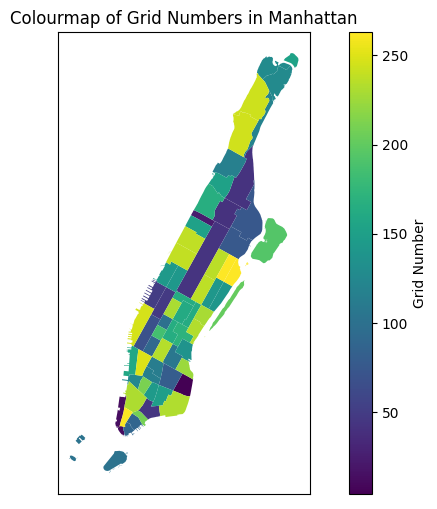

In [9]:
# instantiate plot
fig, ax = plt.subplots(figsize=(10,6))

# plot heatmap of grid numbers
manhattan.plot('LocationID',ax=ax,legend=True,legend_kwds={'label': 'Grid Number'})

# plot styling
ax.set_title('Colourmap of Grid Numbers in Manhattan')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display plot
plt.show()

### 3.2 Initial regressor training and testing

To train the decision tree regressor, the training and testing dataset is split into two random subsets of 80% training data and 20% testing data. The decision tree is configured with an initial maximum tree depth of 10, as a starting point that will later be investigated further. A random state is also assigned to maintain reproducibility.

To train the regressor, the regressor is fitted to the randomly shuffled training data and it resulting fit is scored using the coefficient of determination, R<sup>2</sup>. The regressor is then scored using the testing data, which it has not been fitted to. This provides a measure of how well the predictor generalises over data that it has not previously seen.

In [10]:
def train_decision_tree_regressor(X_data,y_data,max_depth,verbose=False):
    '''
    Splits the input data into randomly ordered 80% training and 20% testing datasets. Instantiates a decision tree
    regressor, fits it to training data and scores it on both the training and testing datasets using the 
    coefficient of determination if verbose.
    
    Inputs:
    > X_data (df): pandas dataframe containing independent variable columns of weather and calendar data.
    > Y_data (df): pandas dataframe containing the dependent variable column of daily demand per city grid.
    > max_depth (int): integer value to constrain the hyperparameter related to depth of the decision tree.
    > verbose (bool): boolean to suppress or allow print statements.
    '''
    # split data into 80% training data and 20% testing data
    X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=14)
    
    # instantiate the decision tree regressor
    regr = DecisionTreeRegressor(max_depth=max_depth,random_state=7)
    
    # fit training data to the regressor
    regr.fit(X_train,y_train)
    
    # print statistics if verbose
    if verbose:
        # score the training fit with coefficient of determination
        print(f'Training R^2: {regr.score(X_train,y_train):.3f}')

        # score the regressors ability to predict testing data with coefficient of determination
        print(f'Testing R^2: {regr.score(X_test,y_test):.3f}')
    
    return regr

In [11]:
## Train and test a decision tree regressor

# define independent and dependent variables from 2018 data
X_data = processed_df.drop(columns='date').loc[:,'grid':]
y_data = processed_df.daily_demand

# define the maximum depth of the decision tree
max_depth = 10

# train and test the decision tree regressor on the selected data
regr = train_decision_tree_regressor(X_data,y_data,max_depth,verbose=True)

Training R^2: 0.927
Testing R^2: 0.915


### 3.3 Cross validation of decision tree regressor

As shown above, the coefficients of the determination of both the testing and training operations are greater than 95%, indicating that the predictor is well-fitted to the training data and that it generalises well for data it has not been fitted to. These are very promising results, but these findings should be further cross-validated using 2019 data.

In [12]:
def cross_val_regressor(regr,X_data,y_data,count,verbose=False):
    '''
    Cross validates the regressor, producing predictions for a subset of the independent dataset X_data and  
    scoring the prediction against the observed values in the dependent dataset y_data for a number of times 
    defined by integer variable 'count'. Prints score statistics if verbose.
    
    Inputs:
    > regr (regressor): scikit-learn regressor type class capable of predict and score functions.
    > X_data (df): pandas dataframe containing independent variable columns of weather and calendar data.
    > Y_data (df): pandas dataframe containing the dependent variable column of daily demand per city grid.
    > count (int): number of iterations of cross validation to perform.
    > verbose (bool): boolean to suppress or allow print statements.
    
    Outputs:
    < cross_scores (df): pandas series containing a coefficient of determination for every cross validation 
        interation performed.
    '''
    # cross validate regressor 
    cross_scores = pd.Series(cross_val_score(regr, X_data, y_data, cv=count),name='cross_val')
    
    # print statistics if verbose
    if verbose:
        print(f'Cross validation statistics: \n{cross_scores.describe(percentiles=[0.01,0.25,0.75,0.99])}')
        
    return cross_scores

Cross validation statistics: 
count    100.000
mean       0.879
std        0.160
min       -0.238
1%         0.059
25%        0.898
50%        0.920
75%        0.936
99%        0.957
max        0.958
Name: cross_val, dtype: float64


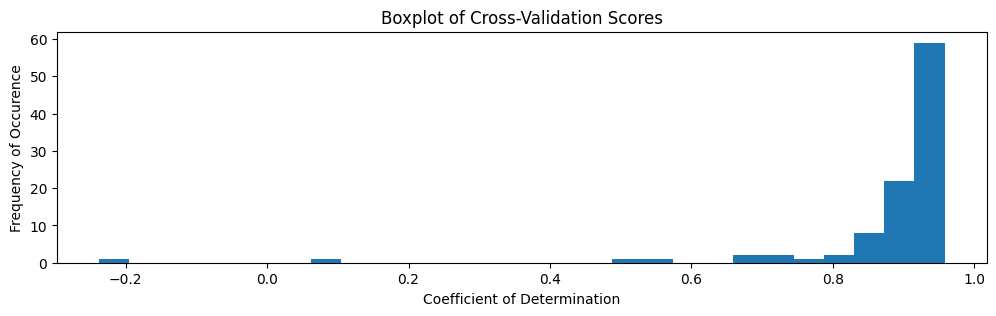

In [13]:
# define independent and dependent variables from the validation data of 2019
X_val = validation_df.drop(columns='date').loc[:,'grid':]
y_val = validation_df.daily_demand

# cross validate the decision tree regressor on unseen validation data
cv_scores = cross_val_regressor(regr,X_val,y_val,count=100,verbose=True)

# instantiate a plot
fig,ax = plt.subplots(figsize=(12,3))

# plot histogram of the cross validation scores
ax.hist(cv_scores,bins=28)

# plot styling
ax.set_title('Boxplot of Cross-Validation Scores')
ax.set_xlabel('Coefficient of Determination')
ax.set_ylabel('Frequency of Occurence')

# display the plot
plt.show()

Cross validation is performed for 100 iterations using the 2019 validation data. The results are compiled into the table and histogram shown above. The histogram shows that the decision tree regressor is able to make most predictions of the validation data with a $R^2$ value of above 80%. The table shows that the 25<sup>th</sup> percentile is close to 90% and the median is 92%. Nevertheless, the histogram also shows that there are clear outliers in the cross validation scores, meaning that some predictions are demonstrably poor. This will be investigated further later in the report. Disregarding these outliers for now, the conclusion that can be drawn from these results is that the decision tree regressor is able to produce accurate predictions of demand when given weather and calendar data for dates that the regressor has not been trained on. 

### 3.4 Further optimisation of decision tree regressor

The regressor in the previous subsections uses an arbitrarily selected initial maximum depth of the decision tree. The model could potentially be further optimised by reducing the maximum depth, or conversely improved by increasing the max depth. Increasing maximum depth of the tree may also result in overfitting the model to the training data. The next plot will explore the cross validation score quartiles and median for a range of maximum depths.

In [14]:
def max_depth_analysis(regr,X_data,y_data,X_val,y_val,last_depth,verbose=False):
    '''
    Iterates over a range of max_depth hyperparameters: training a regressor with a given max_depth setting and 
    then performing 100 cross validation iterations each time, finally adding the results to a cv_results
    dataframe. Plots the lower quartile, median and upper quartile statistics of cross validation scores on a line
    plot against the max_depth values to evaluate the best hyperparameter setting to maximise performance and 
    prevent overfitting.

    Inputs:
    > regr (regressor): scikit-learn regressor type class capable of predict and score functions.
    > X_data (df): pandas dataframe of train and test data containing independent variable columns.
    > Y_data (df): pandas dataframe of train and test data containing the dependent variable column.
    > X_val (df): pandas dataframe of validation data containing independent variable columns.
    > Y_val (df): pandas dataframe of validation data containing the dependent variable column.
    > last_depth (int): integer value for last value in the range of max_depth to iterate over, starting at 1.
    > verbose (bool): boolean to suppress or allow print statements.
    '''
    # instantiate cross validation results dataframe
    cv_results = pd.DataFrame()

    # iterate over a range of max_depths for the decision tree and gather cross validation data
    for max_depth in range(1,last_depth+1):

        # train and test decision tree on 2018 data
        regr = train_decision_tree_regressor(X_data,y_data,max_depth)

        # cross validate regression 100 times on 2019 data
        cross_val = cross_val_regressor(regr,X_val,y_val,count=100)

        # insert cross validation scores into results dataframe
        cv_results.insert(loc=0,column=max_depth,value=cross_val)
     
        if verbose:
            # print progress
            print(f'Max Depth: {max_depth}/{last_depth}')
    
    # instantiate max depth against cross validation scores plot
    fig,ax = plt.subplots(figsize=(10,5))

    # define max depths array
    depths = cv_results.columns.to_numpy()

    # calculcate lower and upper quartiles and median of cross validation scores
    q1s = cv_results.quantile(0.25,axis=0)
    medians = cv_results.median(axis=0)
    q3s = cv_results.quantile(0.75,axis=0)

    #plot lower and upper quartiles and median scores against max depths
    ax.plot(depths,q1s,'orangered')
    ax.plot(depths,medians,'steelblue')
    ax.plot(q3s,'seagreen')

    # add plot styling
    ax.legend(['Lower Quartile','Median','Upper Quartile'])
    ax.set_xlabel('Decision Tree Max Depth')
    ax.set_ylabel('Coefficient of Determination')
    ax.set_title('Cross Validation Results for Range of Decision Tree Max Depths')
    ax.set_xlim([0,21])
    ax.set_xticks(range(1,21,2))
    ax.set_ylim([0,1])

    # find maximum median score and at which depth it occurs
    max_values = [np.max(q1s),np.max(medians),np.max(q3s)]
    depths_at_max = [depths[np.argmax(q1s)],depths[np.argmax(medians)],depths[np.argmax(q3s)]]
    names = ['Q1','Median','Q3']
                                                  
    # add an arrow annotation where scores are max
    for i in range(3):                                            
        ax.annotate(f'Max {names[i]}: ({depths_at_max[i]},{max_values[i]:.3f})',
                    xy=(depths_at_max[i], max_values[i]), xycoords='data',
                    xytext=(25, -40*(i+1)), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->',connectionstyle='angle,angleA=0,angleB=90,rad=25'))

    # display plot
    plt.show()

Max Depth: 1/20
Max Depth: 2/20
Max Depth: 3/20
Max Depth: 4/20
Max Depth: 5/20
Max Depth: 6/20
Max Depth: 7/20
Max Depth: 8/20
Max Depth: 9/20
Max Depth: 10/20
Max Depth: 11/20
Max Depth: 12/20
Max Depth: 13/20
Max Depth: 14/20
Max Depth: 15/20
Max Depth: 16/20
Max Depth: 17/20
Max Depth: 18/20
Max Depth: 19/20
Max Depth: 20/20


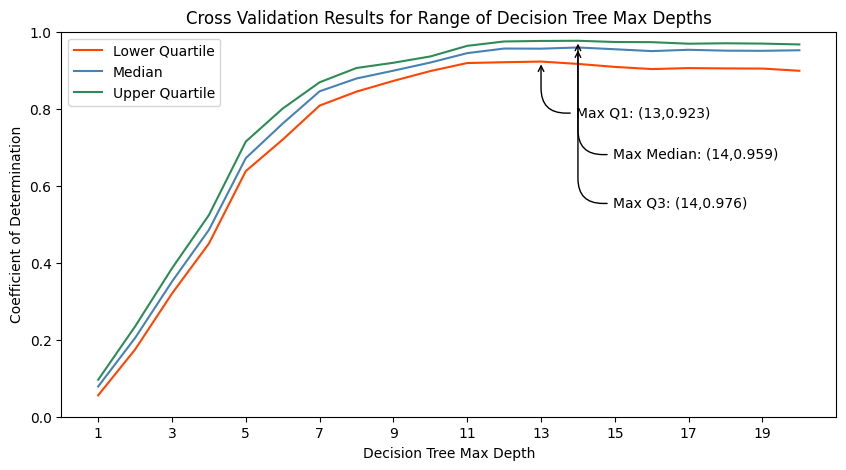

In [15]:
## Perform an analysis of max depth of the decision tree to determine point where model starts to over-fit
max_depth_analysis(regr,X_data,y_data,X_val,y_val,last_depth=20,verbose=True)

The plot shown above shows the lower quartile, median and upper quartile of the cross validation scores against a range of maximum tree depths from 1 to 20. The plot shows that the decision tree regressor is able to improve median performance until a max depth of 14, after which the coefficient of determination plateaus. However, the lower quartile is unable to improve beyond a max depth of 13. A balance should be found between prediciton accuracy and precision: setting the max depth to 13 improves accuracy as the predictor is more often accurate, while setting the max depth to 14 marginally improves precision of the accurate predictions. As the effect of accuracy is greater than that of precision, the final maximum depth of the decision tree is set to 13.

### 3.5 Demand prediction using decision tree regressor

The final configuration of the decision tree regressor is then used to make a prediction of the validation dataset in 2019, and this prediction is visualised below. Again, the prediction is performed on a day in 2019, as this the predictor has only been validated on pre-COVID data. Theoretically, the prediction could also be performed for a date in 2022, but the decision tree has not been trained to account for the effect of COVID and other factors of taxi trends over time.

In [16]:
def predict_demand(regr,date,borough):
    '''
    Compiles calendar and weather data all grids within a defined New York City borough on a defined date, then
    uses a scikit-learn regressor to produce a demand prediction for that date. The prediction is appended to a 
    geopandas dataframe.
    
    Inputs:
    > regr (regressor): scikit-learn regressor type class capable of predict and score functions.
    > date (datetime64): numpy datetime date for day to perform prediction of.
    > borough (gdf): geopandas dataframe of all zones within a selected borough.
    
    Outputs:
    < predict_df (gdf): geopandas dataframe of demand per grid and coordinate shapes of all borough grids
    '''
    # instantiate calendar dataframe with grids in desired borough
    calendar_df = pd.DataFrame(borough.index.to_numpy(),columns=['grid'])

    # add calendar elements to calendar dataframe
    calendar_df['date'] = date
    calendar_df['weekday'] = calendar_df.date.dt.weekday
    calendar_df['month'] = calendar_df.date.dt.month
    calendar_df['quarter'] = calendar_df.date.dt.quarter

    # obtain daily weather dataframe
    weather_df = get_weather_data(calendar_df,manhattan)

    # merge taxi and weather dataframes to prediction dataframe
    predict_df = calendar_df.merge(weather_df,on=['date','grid'],how='inner',validate='one_to_one')

    # predict demand using decision tree regressor and add to dataframe
    predict_df.insert(0,column='demand_prediction',value=np.round(regr.predict(predict_df.drop(columns='date')),0))

    # merge borough geometries and zones onto prediction dataframe
    predict_df = predict_df.merge(borough.loc[:,['geometry','zone']],how='left',left_on='grid',right_index=True,
                                  validate='one_to_one')
    
    # drop date from dataframe
    predict_df.drop(columns='date',inplace=True)
    
    # set grid to index
    predict_df.index = predict_df.pop('grid')
    
    # change prediction dataframe from pandas to geopandas, setting to New York City's coordinate reference system
    predict_df = geopandas.GeoDataFrame(predict_df,geometry=predict_df.geometry,crs='EPSG:32118')
    
    return predict_df

In [17]:
## Produce a daily prediction for demand and calculate grids with predicted surge demand

# define independent and dependent variables from the validation data of 2019,
# this time without dropping date column
X_val = validation_df.loc[:,'grid':]
y_val = validation_df.loc[:,['date','grid','daily_demand']].set_index(['date','grid'],drop=True)

# define the maximum depth of the decision tree
max_depth = 14

# train and test decision tree on 2018 data
regr = train_decision_tree_regressor(X_data,y_data,max_depth)

# set desired date for prediction
date = np.datetime64('2019-12-06')

# predict demand for desired date
predict_df = predict_demand(regr,date,manhattan)

# calculate median demand per grid in 2019 using validation data
predict_df['demand_median'] = validation_df.groupby('grid').daily_demand.median()

# calculate percent predicted demand from median
predict_df['demand_%'] = predict_df.demand_prediction.div(predict_df.demand_median.abs()).mul(100).round(3)

# calculate median fare per grid in 2019 using validation data
predict_df['fare_median'] = validation_df.groupby('grid').daily_fare.median()

# calculate surge demand by multiplying percent difference and median fare
predict_df['demand_surge'] = predict_df['demand_%'].div(100).mul(predict_df.fare_median).round(2)

In [18]:
map_df = predict_df.loc[:,['geometry','zone','demand_prediction','demand_median','demand_%','fare_median',
                           'demand_surge']]

map_df.explore('demand_%',vmax=map_df['demand_%'].quantile(0.95),tiles='CartoDB positron')

The interactive map above shows the predicted demand percentage relative to the monthly median demand, this is calculated as follows:
$$\text{% difference} = \frac{\text{predicted}}{abs(\text{median})} \cdot 100\%$$

The purple zones indicate the lowest demand relative to the median demand, while the yellow zones indicate the highest predicted increase in demand. The interpretation of this heatmap has some caveats. Namely, the percenteage increase for some zones is large because their median demand is low. For example, the islands called Governor's Island and Ellis Island to the south of Manhattan and Marble Hill to the north all have a median demand of 3 and a predicted demand of 6, therefore the demand percentage is 300%. These are outliers, and therefore the colour map is bounded to the 95th percentile to reveal more interesting information.

Disregarding these outliers reveals the zones Alphabet City, Lower East Side and Two Bridges/Seward Park in grids 4, 148 and 232, respectively, south east of Manhattan. These zones have predicted respective demands of 178%, 180% and 179% of their median values. Therefore, these zones are good candidates for the taxi management company to send their taxis to pick up customers. Additionally, the zones in light green just north of central park, such as Morningside Heights, Manhattan Valley and East Harlem North have predicted demand percentages close to 150%. These zones could be good alternatives, as these areas are less central and therefore there is likely less competition from other taxis.

### 3.6 Limitations of the decision tree regressor

The previous analysis of the prediction is a good example of a daily prediction that the taxi management company could perform to make an educated decision where to send their taxi cabs. However, as was previously found in the boxplot, the decision tree regressor does make some outlier predictions that are measurably poor. These predictions may be a result of events happening in the city or national holidays that the prediction algorithm is unable to account for. The following investigation explores the median absolute residuals plotted over time for the validation dataset. The absolute residual is calculated as follows:
$$\text{absolute residual} = abs(\text{observed} - \text{predicted})$$

In [19]:
def calculate_prediction_residuals(regr,X_val,y_val):
    '''
    Uses a scikit-learn regressor to produce a prediction for every date in the independent dataset, then subtracts
    the predicted values from the observed values and takes the absolute value to produce the absolute residual for
    each grid and each date in the independent dataset.
    
    Inputs:
    > regr (regressor): scikit-learn regressor type class capable of predict and score functions.
    > X_val (df): pandas dataframe of validation data containing independent variable columns.
    > Y_val (df): pandas dataframe of validation data containing the dependent variable column.
    
    Outputs:
    < residuals (df): pandas df containing the absolute residuals for all predictions for each grid and each date 
    in the validation dataset.
    '''
    # initialise empty prediction dataframe
    y_val_pred = pd.DataFrame()

    # perform prediction for each date in the X_val dataframe
    for date in X_val.date.unique():

        # predict demand for all grids for given date
        y_pred = pd.DataFrame(regr.predict(X_val.loc[X_val.date==date].drop(columns='date')),
                              columns=['demand_prediction'])

        # add date and grid as columns
        y_pred['grid'] = X_val.loc[X_val.date==date].grid.reset_index(drop=True)
        y_pred['date'] = date

        # set date and grid as a multi-index
        y_pred.set_index(['date','grid'],drop=True,inplace=True)

        # concatenate prediction
        y_val_pred = pd.concat([y_val_pred,y_pred],axis=0)

    # calculate the absolute residuals as absolute value of observed minus predicted demand
    residuals = y_val.daily_demand.sub(y_val_pred.demand_prediction,axis=0).abs()

    return residuals

In [20]:
def residuals_over_time(residuals):
    '''
    Produces a plot of median residuals over time.
    
    Inputs:
    > residuals (df): pandas df containing the absolute residuals for all predictions for each grid and each date 
    in the validation dataset.
    '''
    # instantiate plot
    fig,ax = plt.subplots(figsize=(10,5))

    # find median residuals for predictions and associated dates
    dates = residuals.index.droplevel(1).unique()
    med_residuals = residuals.groupby('date').median()

    # plot median residuals against time
    ax.plot(dates,med_residuals,'steelblue')

    # plot baseline of median residuals at median of all values
    baseline = np.median(med_residuals)
    ax.plot([min(dates),max(dates)],[baseline,baseline],'k')
    
    # add plot styling
    ax.set_xlabel('Time [yyyy-mm]')
    ax.set_ylabel('Median absolute residual number of taxi trips')
    ax.set_title('Timeseries of median absolute prediction residuals')
    ax.legend(['Median absolute residual','Baseline absolute residual'])
    
    # find peaks in max residual greater than 1450 trips
    indices = med_residuals[med_residuals > 1450].index
    peak_dates = med_residuals[indices].index.date
    peak_values = med_residuals[indices]

    # annotate peak values
    for i in range(len(peak_values)-1):
        ax.annotate(f'{peak_dates[i]}',xy=(peak_dates[i], peak_values[i]), xycoords='data',
                        xytext=(-80, 0), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->'))

    # display plot
    plt.show()

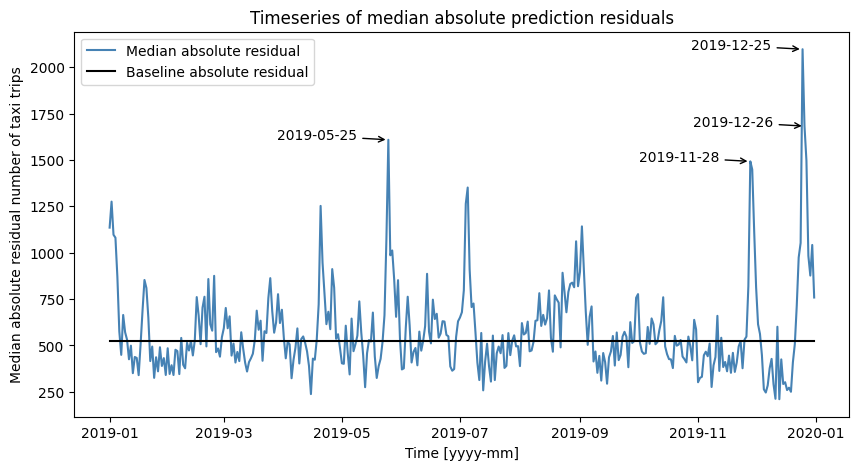

In [21]:
## Investigate prediction residuals over time
# calculate residuals of prediction from regressor for validation data
residuals = calculate_prediction_residuals(regr,X_val,y_val)

# plot residuals over time
residuals_over_time(residuals)

The above figure shows median absolute residuals of the decision tree prediction over the duration of the validation dataset from 2019. First addressing the baseline absolute residual, the median absolute residual is on average approximately 500, meaning that the decision tree predicts demand on average $\pm 500$ trips from the nominal observed value. This is a notable finding, as this brings about the question whether or not the demand prediction is as accurate as the coefficients of determination during cross validation suggested, however the value of 500 trips is not set in context. The below calculation shows that the median daily demand for all grids in Manhattan across the full year is 2403.5. Therefore $\pm 500$ accounts for approximately 20% error in the prediction, which is high but could be considered reasonable. Additionally, it should be considered that this value generalises over the whole borough, which may not mean that the residuals is also 500 in zones with low demand.

In [22]:
# median demand across all of Manhattan for the full year 2019
validation_df.daily_demand.median()

2403.5

More interestingly, looking the prominent spikes shown in the figure, the predictor has increased absolute residuals for particular days of the year, which could be correlated to increased demand due to events or national holidays happening in the city. For example, the spike on the 25<sup>th</sup> of May occurs on Memorial Day weekend, and the spike on the 28<sup>th</sup> of November could be attributable to Thanksgiving, and the Thanksgiving Day Parade occuring in the city centre. The 25<sup>th</sup> and 26<sup>th</sup> of December is when Christmas and Boxing Day are celebrated. For these events and holidays, the prediction model is unable to produce an accurate prediction of demand. Therefore, a more analytical method for recommending optimal taxi pick-up locations should be devised for these special days.

## 4 Analysis of demand due to events and public holidays

### 4.1 Investigating the demand from public holidays

In the previous section, the residuals of the prediction produced by the Decision Tree regressor indicated that it is unsuitable for making accurate predictions during large events and public holidays. Instead of producing a prediction, the recommendation for optimal taxi pick-up locations is based on historical data for these events.

Thanksgiving day will be used as an example in this report for how this historical analysis of a public holiday will be conducted. This is particular holiday is selected as the residual time series plot in the previous section has a substantial spike for this date, and its date can be easily calculated for each year, as it is celebrated on the fourth Thursday of November each year. Expanding this investigation to other public holidays celebrated in New York City throughout the year will require the use of a public holiday and events API, but considering the scope of this project, this is considered potential future development work.

In [23]:
def calendar_interpret(df):
    '''
    Extracts the date and day of week from the pickup datetime, uses the weekday to find the fourth Thursday in 
    the month of the data and save this value to an event_date pandas series. The original dataframe is returned
    with the pickup datetime column replaced with a date column.
    
    Inputs:
    > df (df): pandas dataframe containing taxi data with a column of pickup datetime.
    
    Outputs:
    < df (df): same pandas dataframe with pickup datatime columns replaced by a column of the associated date.
    < event_date (series): pandas series containing the date of the fourth Thursday of the dataframe date range.
    '''
    # add date and weekday columns to the dataframe
    df.insert(0,'date',df.tpep_pickup_datetime.dt.date)
    df.insert(1,'weekday',df.tpep_pickup_datetime.dt.weekday)

    # convert date to datetime type
    df.date = pd.to_datetime(df.date)
    
    # find the fourth Thursday of November (weekday: mon=0, thurs=3, sun=6)
    thurs_dates = df[df.weekday == 3].date.unique()[3]
    year = df.date.dt.year.unique()
    event_date = pd.Series(thurs_dates,index=year)
    
    # drop the datetime and weekday column
    df.drop(columns=['tpep_pickup_datetime','weekday'],inplace=True)
                              
    return df, event_date

In [24]:
def historical_data(years,months,columns,vehicle,path,verbose=False):
    '''
    Imports taxi data of a defined vehicle type, for all desired years and months, with the defined columns. The 
    taxi data is cleaned and calendar data is appended to the taxi data to form a processed dataframe. The
    function also returns a dataframe with all dates of the fourth Thursday for every month and year.
    
    Inputs:
    > years (range or list): desired years to gather taxi data for.
    > months (range or list): desired months to gather taxi data for in each year.
    > columns (list): list of strings for each desired column to extract from the monthly taxi dataset.
    > path (str): local path to folder where data is stored.
    > verbose (bool): boolean to suppress or allow print statements.
    
    Outputs:
    < processed_df (df): pandas dataframe containing all cleaned taxi journey data for given year and month range.
    < dates_df (df): pandas dataframe containing all dates of the fourth Thursdays for all years and months.
    '''
    # instantiate empty dataframe to fill with processed data and event dates for each year
    processed_df = pd.DataFrame()
    dates_df = pd.Series(dtype=object)

    # iterate over multiple years and months
    for year in years:
        for month in months:
            # print progress if verbose
            if verbose:
                print(f'Importing data for {year}-{month}')

            # add zero month if below 10
            if month < 10:
                month = f'0{month}'
                
            # import the taxi data with specified arguments
            raw_df = get_taxi_data(year, month, vehicles=vehicle, columns=columns, save=True, localpath=path)

            # clean data frame for given year and month, with pickup locations restricted to Manhattan
            clean_df = clean_data(raw_df,month,year,manhattan.index)

            # add calendar data to clean data, and drop datatime column
            cal_df, event_date = calendar_interpret(clean_df)

            # concatenate cal dataframe onto processed dataframe, and add event date element to date dataframe
            processed_df = pd.concat([processed_df,clean_df],axis=0,ignore_index=True)
            dates_df = pd.concat([dates_df,event_date],axis=0)
        
    # show memory usage statistics and verify no NaN values
    if verbose:
        print(processed_df.info(memory_usage='deep',show_counts=True))

    return processed_df,dates_df

In [25]:
def event_yearly_demand(hist_df,dates_df,borough,pickupdropoff='PU'):
    '''
    Produces summary data for daily demand for a day of an event, and the median monthly demand to compare it to.
    Calculates percentage demand as the proportion of daily demand to median demand. Compiles the summary data into
    an event geopandas geodataframe.
    
    Inputs:
    > hist_df (df): pandas dataframe containing historical taxi journey data ordered by date and grid.
    > dates_df (df): pandas dataframe containing all dates of events to produce summary data for.
    > borough (gdf): geopandas dataframe of all zones within a selected borough.
    > pickupdropoff (str): string identifying whether to produce summary data for pickup demand or dropoff demand,
        can be either 'PU' or 'DO', respectively.

    Outputs:
    < event_df (gdf): geopandas geodataframe containing summarised demand data for each event date and grid.
    '''
    # initialise event geodataframe, dropping unnecessary columns
    event_df = borough.drop(columns=['Shape_Leng','Shape_Area','borough'])

    for i in range(len(dates_df)):

        # calculate values for pickup or drop-off demand
        if pickupdropoff == 'PU':
            
            # calculate demand per grid on the event date
            event_demand = hist_df.loc[hist_df.date == dates_df.iloc[i]].PULocationID.value_counts()
            
            # calculate monthly median pickup demand per grid for each year
            median_demand  = hist_df[hist_df.date.dt.year == dates_df.iloc[i].year].groupby('date').PULocationID.value_counts().groupby('PULocationID').median()

        elif pickupdropoff == 'DO':
            
            # calculate demand per grid on the event date
            event_demand = hist_df.loc[hist_df.date == dates_df.iloc[i]].DOLocationID.value_counts()
            
            # calculate monthly median dropoff demand per grid for each year
            median_demand  = hist_df[hist_df.date.dt.year == dates_df.iloc[i].year].groupby('date').DOLocationID.value_counts().groupby('DOLocationID').median()
            
        # calculate percent demand on the event day relative to the median demand
        percent_demand = event_demand.div(median_demand)

        # insert demand and percent demand into event geodataframe
        event_df[f'{pickupdropoff}_demand_{dates_df.iloc[i].year}'] = event_demand
        event_df[f'{pickupdropoff}_%_demand_{dates_df.iloc[i].year}'] = percent_demand
        event_df[f'{pickupdropoff}_median_{dates_df.iloc[i].year}'] = median_demand
        
    return event_df

In [26]:
def plot_event_heatmap(event_df,year,column_name,event_name,dropoffpickup='PU'):
    '''
    Plots a heatmap of a event_df geodataframe data column.
    
    Inputs:
    > event_df (gdf): geopandas geodataframe containing summarised demand data for each event date and grid.
    > year (int): year of the event to plot the data for.
    > column_name (str): string of the name for the column to visualise the heatmap data of. Can be one of:
        'demand','%_demand' or 'median'.
    > event_name (str): string of the name of the event to use in the plot title.
    > dropoffpickup (str): string identifying whether to visualise data for pickup or dropoff demand, can be either
        'PU' or 'DO', respectively.
    '''
    # select columns of interest
    g_event_df = event_df.loc[:,['geometry','zone',f'{dropoffpickup}_demand_{year}',
                                 f'{dropoffpickup}_%_demand_{year}',f'{dropoffpickup}_median_{year}']]
    
    # title case the column name for plot title and legend
    title = column_name.title().replace('_',' ')
    
    # instantiate plot
    fig, ax = plt.subplots(figsize=(6,6))

    # plot heatmap of grid numbers
    g_event_df.fillna(0).plot(f'{dropoffpickup}_{column_name}_{year}',cmap='OrRd',ax=ax,vmin=0.4,vmax=1.7,
                              legend=True,legend_kwds={'label': f'{title} of Median'},figsize=(6,6))

    # plot styling
    ax.set_title(f'Heatmap of {title} during {event_name} {year}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display plot
    fig.show()

In [27]:
## Import and process data

# import taxi zones data
zones, manhattan = import_taxi_zones(taxi_zone_path,'Manhattan')

# taxi data import arguments
columns = ['tpep_pickup_datetime','fare_amount','PULocationID','DOLocationID']
years = range(2013,2019)
months = [11]
vehicle = 'yellow'

# import and process the desired data frame
hist_df,dates_df = historical_data(years,months,columns,vehicle,taxi_data_path,verbose=True)

# interpret historical dataframe to produce pick-up demand during Thanksgiving for each year
holiday_df = event_yearly_demand(hist_df,dates_df,manhattan,'PU')

Importing data for 2013-11
Importing data for 2014-11
Importing data for 2015-11
Importing data for 2016-11
Importing data for 2017-11
Importing data for 2018-11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60102418 entries, 0 to 60102417
Data columns (total 4 columns):
 #   Column        Non-Null Count     Dtype         
---  ------        --------------     -----         
 0   date          60102418 non-null  datetime64[ns]
 1   fare_amount   60102418 non-null  float64       
 2   PULocationID  60102418 non-null  int64         
 3   DOLocationID  60102418 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.8 GB
None


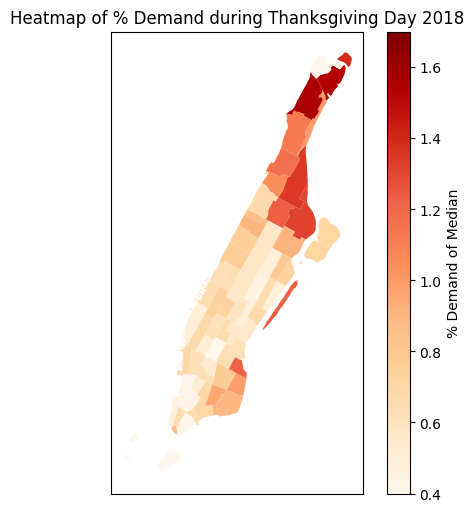

In [28]:
# plot a heatmap of thanksgiving day pickup demand
plot_event_heatmap(holiday_df,year=2018,column_name='%_demand',event_name='Thanksgiving Day')

A heatmap of the percentage demand during Thanksgiving Day is plotted above to get a general idea of how demand during Thanksgiving Day diverges from the median monthly demand of November. What is immediately apparent is that general demand is very low compared to the median in the city centre. This could be attributed to people leaving the city to spend time with family elsewhere in the country. Therefore, the spike in absolute residuals associated with Thanksgiving day in the previous section is actually a negative residual spike, indicating that the prediction algorithm over-estimated demand. It is thus notable that public holidays could both potentially decrease and increase general taxi.

Meanwhile, demand north of the city centre in the Harlem, Washington Heights and Inwood Hill Park neighbourhoods is increased beyond their median. It could therefore be beneficial for the taxi management company to send their taxis to the outskirts of Manhattan to find customers outside the city centre. However, this considers only the data for 2018, and the latter trend should be validated using data from previous years.

In [29]:
## produce an interactive heatmap with a slider bar to set the year to be plotted

# instantiate the slider bar that spans the years of data available
@widgets.interact(year=(min(years), max(years), 1))

# update the plot when the slider is changed.
def update(year = min(years)):
    '''
    Updates the plot containing data for the slider's value of year, initial state is the minimum year, and the 
    input can range between the minimum and maximum year for which there is data.
    '''
    plot_event_heatmap(holiday_df,year,column_name='%_demand',event_name='Thanksgiving Day')

interactive(children=(IntSlider(value=2013, description='year', max=2018, min=2013), Output()), _dom_classes=(…

The above interactive figure shows a heatmap of percentage demand on Thanksgiving day relative to the median monthly demand for each year from 2012 to 2018, where the slider can be used to adjust the year shown. The figure shows that the trend of low demand in the city centre and high demand in the northern neighbourhoods is consistent for all years, and thus the recommendation for the taxi management company to send their taxis away from the city centre and to the northern neighbourhoods during Thanksgiving holds.

### 4.2 Investigating the demand from city events

The previous section investigated the effect of public holidays on the taxi demand in Manhattan. These public holidays have the potential to affect the city as a whole, whereas events within the city may only affect the demand in some particular grids. The following investigation will investigate an example of how an event may affect demand on a per-grid basis.

The method that is used to investigate the effect of an event on demand is to explore where customers are dropped off to locate where the event is held, and then retrace the customers' trips to where they were originally picked up. The event that is used as an example in this report is the Summary Fancy Food Show held in the Jacob Javits Convention Center [2]. This event requires people to be physically present as it involves eating, and the expected number of visitors is high as it is held in a convention centre. In 2018, this event was held between June 30<sup>th</sup> and July 2<sup>nd</sup>. The middle day is investigated, therefore the drop-off demand for will be plotted below for this day.

In [30]:
# define the dates of interest
showdates_df = pd.Series(np.datetime64('2018-07-01'))
showdates_df.index = showdates_df.dt.year

# taxi data import arguments
columns = ['tpep_pickup_datetime','fare_amount','PULocationID','DOLocationID']
event_year = showdates_df.dt.year.unique()
event_months = showdates_df.dt.month.unique()
vehicle = 'yellow'

# import and process the desired data frame
hist_df,_ = historical_data(event_year,event_months,columns,vehicle,taxi_data_path,verbose=False)

# interpret historical dataframe to produce drop-off demand during the Summer Fancy Food Show
event_df = event_yearly_demand(hist_df,showdates_df,manhattan,pickupdropoff='DO')

# select columns of interest to show in tooltip
g_event_df = event_df.loc[:,['geometry','zone',f'DO_demand_2018',f'DO_%_demand_2018',f'DO_median_2018']]
    

# plot a heatmap of the middle day of the Fancy Food Show dropoff demand
g_event_df.fillna(0).explore(f'DO_%_demand_2018',cmap='OrRd',vmin=0.4,vmax=1.7,legend=True,
                             tiles='CartoDB positron',legend_kwds={'caption': f'% Demand of Median'})

The above interactive heatmap shows percentage demand relative to the median demand for Manhattan. The greatest demand increase is in Marble Hill at the northern-most point, but this should be disregarded as demand is increased from 7 to 12 pick-ups. More important is the red spot below the 'Weehawken' label for the West Chelsea/Hudson Yards neighbourhood. This neighbourhood is where the Jacob Javits Convention Center is located, and thus where the Fancy Food Show is held. The grid has a percentage dropoff demand increase of 44%, accounting for 2,000 additional drop-offs in this zone.

These 2,000 additional trips should be taken advantage of by the taxi management company to generate more profits. This can only be done once it is known where these additional trips are originating from, and then sending the taxis to pick up customers from these zones. Therefore, the pick-up demand is investigated for all passengers that are dropped off in the zone where the event venue is.

In [31]:
def origin_demand(hist_df,event_df,dates_df,grid_number):
    '''
    Produces summary data for daily demand of pick up locations for journeys that end at a defined drop-off grid
    number, and the median monthly demand to compare it to. Calculates percentage demand as the proportion of daily
    demand to median demand. Compiles the summary data into an event geopandas geodataframe.
    
    Inputs:
    > hist_df (df): pandas dataframe containing historical taxi journey data ordered by date and grid.
    > event_df (gdf): geopandas geodataframe containing summarised dropoff demand data for each event date and 
        grid.
    > dates_df (df): pandas dataframe containing all dates of events to produce summary data for.
    > grid_number (int): integer value of grid number where the journeys end for which to investigate pickup demand
    distribution.

    Outputs:
    < event_df (gdf): geopandas geodataframe containing summarised pickup and dropoff demand data for each event
    date and grid.
    '''
    for i in range(len(dates_df)):

        # calculate demand per grid on the event date
        mask = (hist_df.date == dates_df.iloc[i])&(hist_df.DOLocationID == grid_number)
        event_demand = hist_df.loc[mask].PULocationID.value_counts()

        # calculate monthly median pickup demand per grid for each year
        mask = (hist_df.date.dt.year == dates_df.iloc[i].year)&(hist_df.DOLocationID == grid_number)
        median_demand  = hist_df[mask].groupby('date').PULocationID.value_counts().groupby('PULocationID').median()

        # calculate percent demand on the event day relative to the median demand
        percent_demand = event_demand.div(median_demand)

        # insert demand and percent demand into event geodataframe
        event_df[f'PU_demand_{dates_df.iloc[i].year}'] = event_demand
        event_df[f'PU_%_demand_{dates_df.iloc[i].year}'] = percent_demand
        event_df[f'PU_median_{dates_df.iloc[i].year}'] = median_demand
        
    return event_df

In [33]:
# calculate pickup demand across city for customers dropped off in grid 246, West Chelsea/Hudson Yards
event_df = origin_demand(hist_df,event_df,showdates_df,grid_number=246)

# select columns of interest
g_event_df = event_df.loc[:,['geometry','zone',f'PU_demand_2018',f'PU_%_demand_2018',f'PU_median_2018']] 

# plot a heatmap of the middle day of the Fancy Food Show dropoff demand
g_event_df.fillna(0).explore(f'PU_%_demand_2018',cmap='OrRd',legend=True,
                             tiles='CartoDB positron',legend_kwds={'caption': f'% Demand of Median'})

The interactive heatmap for pick-ups around Manhattan to be dropped off in West Chelsea/Hudson Yards shows increased demand from median in many of the island's zones, however this demand is shown percentage-wise. Many of the grids have increased demand similar to a median demand of 34 to a demand of 69 on the day of the demand. Therefore, it is prudent to look at pick up demand instead of percentage demand. This is plotted in the heatmap below.

This heatmap shows the greatest demand that could be correlated to the Fancy Food Show originating from Times Square, Clinton East and Penn Station. These areas would therefore be good recommendations for the taxis to be sent to in the following year. However, these areas are also very busy and taxi competition is likely high. Another recommendation should be East Chelsea and Clinton West, which have high demand and high percentage demand increases, while being a bit further outside the city centre.

In [34]:
# plot a heatmap of the middle day of the Fancy Food Show dropoff demand
g_event_df.fillna(0).explore(f'PU_demand_2018',cmap='OrRd',legend=True,
                             tiles='CartoDB positron',legend_kwds={'caption': f'Pickup Demand'})

## 5 Conclusion

The aim of this report was to analyse the taxi trip dataset published by the New York City Taxi and Limousine Commission (NYC TLC) and extract useful information to provide consultancy services to a taxi management company. This aim was accomplished in two ways: first, historical data is used to train a decision tree regressor that is then able to predict demand accross Manhattan using predicted weather and calendar data. Secondly, to build upon the limitations of the prediction algorithm, analytical investigations are shown as examples for how historical taxi data for events and public holidays can be leveraged to produce recommended areas for taxis to patrol for potential customers.

The decision tree regressor showed good prediction performance across the training, testing and validation datasets, with coefficients of determination generally above 90%. The algorithm is able to generate predictions for demand in all Manhattan grids, which could then be interpretted to make an educated decision on where to send the taxis to optimise profits. Nevertheless, the predictions were found to have a baseline residual level between observed and predicted demand of 500 journeys, which should be investigated if the scope of this project is extended. Additionally, the residuals were notably high for some particular days in the year, which could be attributed to national holidays and events.

The analysis performed on these national holidays involved comparing demand levels per grid on these days to the median values of these grids using heatmaps. The heatmaps could be used to show general trends across the city for multiple years for the Thanksgiving public holiday, as well as detailed trends on a per-grid basis using interactive heatmaps for city events, such as the Summer Fancy Food Show. Based on these heatmaps, recommended areas for the taxi management company to send their taxis to could be produced.

As a result, the decision tree predictor and heatmap analysis together help formulate strategic locations within Manhattan on a daily basis to optimise the taxi management company's passenger pick-up rate.

## References

1. Géron, A 2017, Hands-On Machine Learning with Scikit-Learn and TensorFlow : Concepts, Tools, and Techniques to Build Intelligent Systems, O'Reilly Media, Incorporated, Sebastopol. Available from: ProQuest Ebook Central. [29 November 2022].

2. Specialty Foods Association, 2022, Summer Fancy Food Show, New York City. Available from: https://www.specialtyfood.com/shows-events/summer-fancy-food-show/ [30 November 2022].